https://www.liveinternet.ru/community/rss_rss_hh_full/post418940841/



----

Kohonen, T. (1988), Learning Vector Quantization, Neural Networks, 1 (suppl 1), 303.

https://sci2s.ugr.es/keel/pdf/algorithm/articulo/1990-Kohonen-PIEEE.pdf

каждый нейрон первого (распределительного) слоя    
соединен со всеми нейронами второго (выходного) слоя,  
которые расположены в виде двумерной решетки.

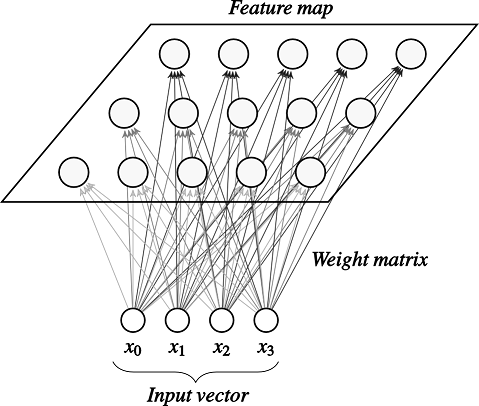

https://www.liveinternet.ru/community/rss_rss_hh_full/post418940841/

Задача векторного квантования состоит в наилучшей аппроксимации всей совокупности векторов данных ${\displaystyle k}$
кодовыми векторами ${\displaystyle W_{j}}$.

Самоорганизующиеся карты Кохонена также аппроксимируют данные, 
однако при наличии дополнительной структуры в совокупности кодовых векторов (англ. codebook).

Каждая точка данных отображается соответствующим кодовым вектором из решётки. 

Так получают представление данных на плоскости («карту данных»). 

При отображении этих слоёв полезен аппарат географических информационных систем (ГИС).   
В ГИС подложкой для изображения информационных слоев служит географическая карта.

$$\|x,w\|+b $$

https://masters.donntu.org/2018/fknt/shumskyi/library/article8.pdf

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
class SOMNetwork():
    def __init__(self, input_dim, dim=10, sigma=None, learning_rate=0.1, tay2=1000, dtype=tf.float32):
        if not sigma:
            sigma = dim / 2
        self.dtype = dtype
        #constants
        self.dim = tf.constant(dim, dtype=tf.int64)
        self.learning_rate = tf.constant(learning_rate, dtype=dtype, name='learning_rate')
        self.sigma = tf.constant(sigma, dtype=dtype, name='sigma')
        self.tay1 = tf.constant(1000/np.log(sigma), dtype=dtype, name='tay1')
        self.minsigma = tf.constant(sigma * np.exp(-1000/(1000/np.log(sigma))), dtype=dtype, name='min_sigma')
        self.tay2 = tf.constant(tay2, dtype=dtype, name='tay2')
        #input vector
        self.x = tf.placeholder(shape=[input_dim], dtype=dtype, name='input')
        #iteration number
        self.n = tf.placeholder(dtype=dtype, name='iteration')
        #variables
        self.w = tf.Variable(tf.random_uniform([dim*dim, input_dim], minval=-1, maxval=1, dtype=dtype),
            dtype=dtype, name='weights')
        #helper
        self.positions = tf.where(tf.fill([dim, dim], True))

    def feed(self, input):
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            init.run()
            win_index = sess.run(self.__competition(), feed_dict={self.x: input})
            win_index_2d = np.array([
                win_index//self.dim.eval(), 
                win_index-win_index//self.dim.eval()*self.dim.eval(),
            ])
        return win_index_2d


    def training_op(self):
        win_index = self.__competition('train_')
        with tf.name_scope('cooperation') as scope:
            coop_dist = tf.sqrt(tf.reduce_sum(tf.square(tf.cast(self.positions -
                [win_index//self.dim, win_index-win_index//self.dim*self.dim], 
                dtype=self.dtype)), axis=1))
            sigma = tf.cond(self.n > 1000, lambda: self.minsigma, lambda: self.sigma * tf.exp(-self.n/self.tay1))
            sigma_summary = tf.summary.scalar('Sigma', sigma)
            tnh = tf.exp(-tf.square(coop_dist) / (2 * tf.square(sigma))) # topological neighbourhood
        with tf.name_scope('adaptation') as scope:
            lr = self.learning_rate * tf.exp(-self.n/self.tay2)
            minlr = tf.constant(0.01, dtype=self.dtype, name='min_learning_rate')
            lr = tf.cond(lr <= minlr, lambda: minlr, lambda: lr)
            # lr_summary = tf.summary.scalar('Learning_rate', lr)
            lr_summary = tf.summary.scalar('learning_rate', lr)
            delta = tf.transpose(lr * tnh * tf.transpose(self.x - self.w))
            training_op = tf.assign(self.w, self.w + delta)
        return training_op, lr_summary, sigma_summary

    def __competition(self, info=''):
        with tf.name_scope(info+'competition') as scope:
            distance = tf.sqrt(tf.reduce_sum(tf.square(self.x - self.w), axis=1))
        return tf.argmin(distance, axis=0)

In [4]:
from tqdm import tqdm

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
250000it [04:26, 939.14it/s] 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


266.20546102523804


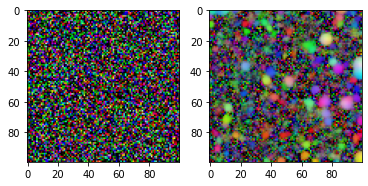

CPU times: user 4min 28s, sys: 30.9 s, total: 4min 59s
Wall time: 4min 26s


In [5]:
%%time

som_dim = 100
som = SOMNetwork(input_dim=3, dim=som_dim, dtype=tf.float64, sigma=3)

test_data = np.random.uniform(0, 1, (250000, 3))
training_op, lr_summary, sigma_summary = som.training_op()

init = tf.global_variables_initializer()
writer = tf.summary.FileWriter('./logs/', tf.get_default_graph())

with tf.Session() as sess:
    init.run()
    img1 = tf.reshape( som.w, [som_dim,som_dim,-1] ).eval()

    for i, color_data in tqdm(enumerate(test_data)):
        sess.run(training_op, feed_dict={som.x: color_data, som.n:i})
   
    img2 = tf.reshape(som.w, [som_dim,som_dim,-1]).eval()

writer.close()
plt.show()        

In [40]:
# def arr2img(x):
#     x_min,x_max = x.min(),x.max()
#     return np.floor(((x-x_min)/(x_max-x_min))*254).astype(np.int)
    

# fig,ax = plt.subplots(1,2,figsize=(15,7))
# ax[0].imshow( arr2img(img1) )
# ax[1].imshow( arr2img(img2) )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


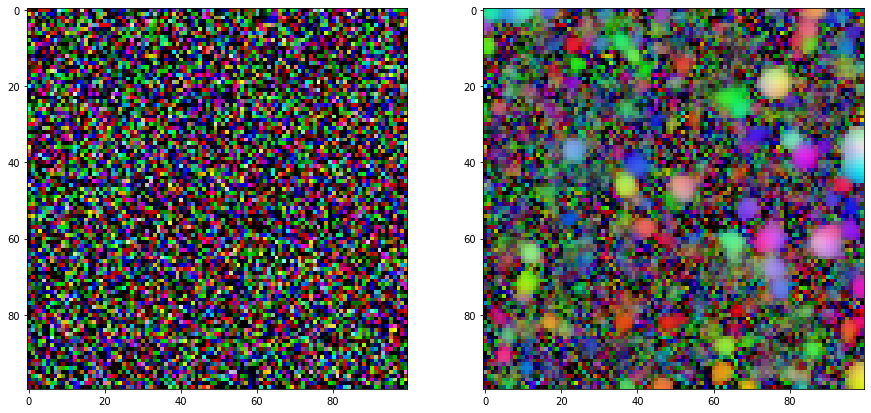

In [42]:
fig,ax = plt.subplots(1,2,figsize=(15,7))
ax[0].imshow( img1 )
ax[1].imshow( img2 )

In [6]:
# weight